In [15]:
from game_utils.ContinuousPokerVariants.LCP import LCP, LCP_utils
from game_utils.ContinuousPokerVariants.NLCP import NLCP
from game_utils.ContinuousPokerVariants.FBCP import FBCP
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

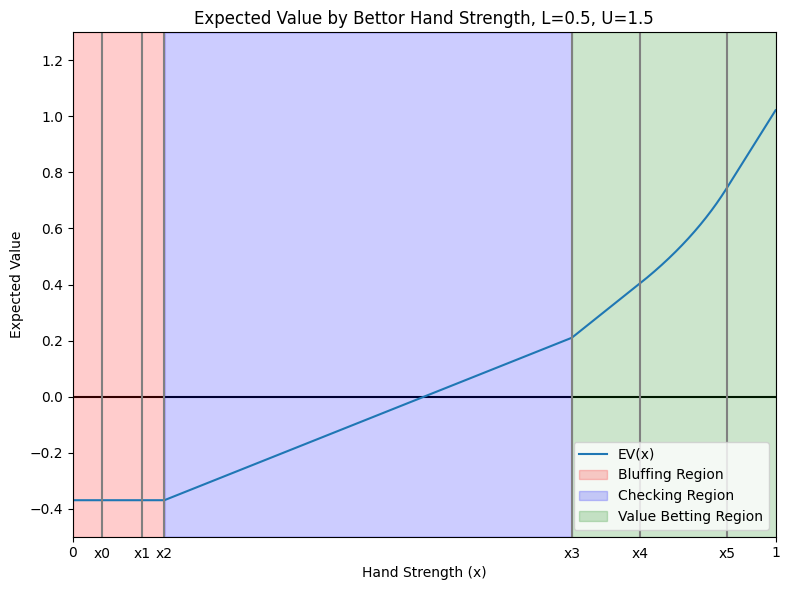

In [16]:
# a line graph of the EV(x) over a range of x values for fixed L and U
game_params = {"L": 0.5, "U": 1.5}
fig, ax = plt.subplots(figsize=(8, 6))
ylims = [-0.5, 1.3]
xlims = [0, 1]

# EV(x) line graph
X = np.linspace(0, 1, 1001)
payoffs = []
for x in X:
    payoff = LCP.expected_payoff_x(game_params, x)
    payoffs.append(payoff)
ax.plot(X, payoffs, label="EV(x)")
ax.set_title("Expected Value by Bettor Hand Strength, L=0.5, U=1.5")
ax.set_xlabel("Hand Strength (x)")
ax.set_ylabel("Expected Value")
ax.axhline(y=0, color='black', zorder=0)

# Get x values for vertical lines
x0 = LCP_utils.compute_x0(game_params)
x1 = LCP_utils.compute_x1(game_params)
x2 = LCP_utils.compute_x2(game_params)
x3 = LCP_utils.compute_x3(game_params)
x4 = LCP_utils.compute_x4(game_params)
x5 = LCP_utils.compute_x5(game_params)

# Plot vertical lines and add labels
x_values = [x0, x1, x2, x3, x4, x5]
x_labels = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']

for x, label in zip(x_values, x_labels):
    ax.vlines(x, ylims[0], ylims[1], color="grey")
    ax.text(x, ylims[0]-0.035, label, ha='center', va='top')

# Add shaded regions
ax.fill_between(X, ylims[0], ylims[1], where=(X >= 0) & (X <= x2), alpha=0.2, color='red', label='Bluffing Region')
ax.fill_between(X, ylims[0], ylims[1], where=(X >= x2) & (X <= x3), alpha=0.2, color='blue', label='Checking Region') 
ax.fill_between(X, ylims[0], ylims[1], where=(X >= x3) & (X <= 1), alpha=0.2, color='green', label='Value Betting Region')
ax.legend()

ax.set_xlim([0, 1])
ax.set_ylim([-0.5, 1.3])
ax.set_xticks([0, 1])
plt.tight_layout()
plt.show()


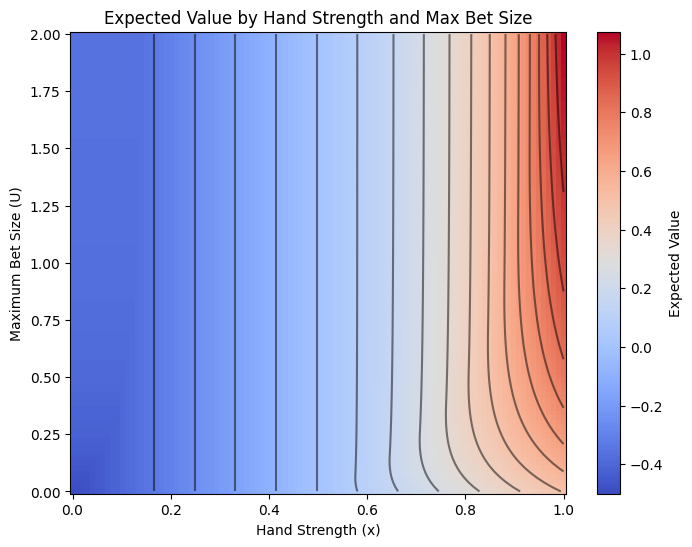

In [17]:
# Heatmap of EV(x) for x from 0 to 1, and U from 0 to 2
bth = LCP.bluff_threshold(game_params)

# Create a grid of x values from 0 to 1 and U values from 0 to 2
x_vals = np.linspace(0, 1, 100)
U_vals = np.linspace(0, 2, 100)
X, U = np.meshgrid(x_vals, U_vals)

# Initialize array to store payoffs
payoffs = np.zeros_like(X)

# Compute payoff for each (x,U) pair
for i in range(len(U_vals)):
    for j in range(len(x_vals)):
        game_params = {"L": 0, "U": U_vals[i]}
        payoffs[i,j] = LCP.expected_payoff_x(game_params, x_vals[j])

# Create figure and plot heatmap
plt.figure(figsize=(8,6))
plt.pcolormesh(X, U, payoffs, shading='auto', cmap='coolwarm')
plt.colorbar(label='Expected Value')

# # Add level curves on same axes
levels = np.linspace(np.min(payoffs), np.max(payoffs), 20)
plt.contour(X[:, x_vals>bth], U[:, x_vals>bth], payoffs[:, x_vals>bth], levels=levels, colors='black', linestyles='solid', alpha=0.5)

plt.xlabel('Hand Strength (x)')
plt.ylabel('Maximum Bet Size (U)')
plt.title('Expected Value by Hand Strength and Max Bet Size')
plt.show()


/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_51419/1742592455.py:18: RuntimeWarning: invalid value encountered in scalar divide
  normalized_payoffs = [(payoff - mean_payoff) / STD for payoff in payoffs]


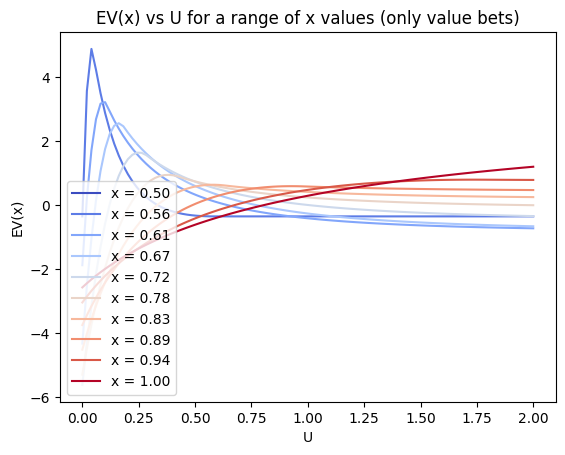

In [18]:
# EV(x) vs U for a range of x values (only value bets)
# vth = LCP.value_threshold(game_params)
U_vals = np.linspace(0, 2, 100)

x_vals = np.linspace(0.5, 1, 10)

# Create a colormap from blue to red
colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_vals)))

for i, x in enumerate(x_vals):
    payoffs = []
    for j, u in enumerate(U_vals):
        game_params = {"L": 0, "U": u}
        payoff = LCP.expected_payoff_x(game_params, x)
        payoffs.append(payoff)
    mean_payoff = np.mean(payoffs)
    STD = np.std(payoffs)
    normalized_payoffs = [(payoff - mean_payoff) / STD for payoff in payoffs]
    plt.plot(U_vals, normalized_payoffs, label=f"x = {x:.2f}", color=colors[i])
plt.legend()
plt.title("EV(x) vs U for a range of x values (only value bets)")
plt.xlabel("U")
plt.ylabel("EV(x)")
plt.show()

# Notice the smaller x have decreasing EV(x) as U increases past a certain point.

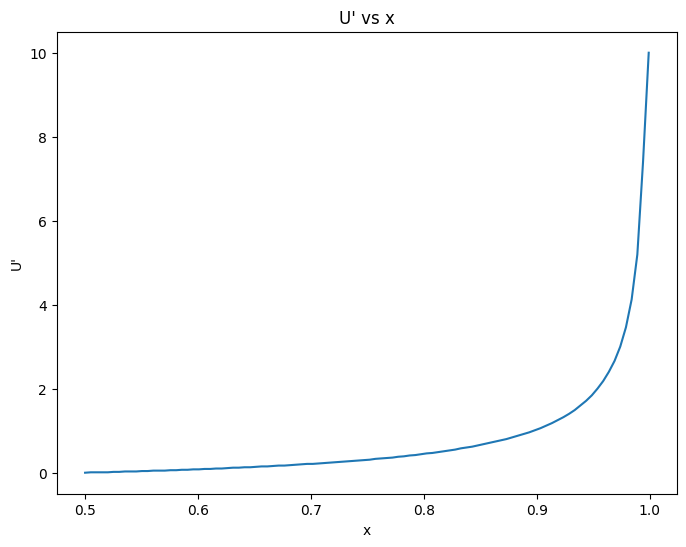

In [19]:
def decreasing_past_index(arr, index):
    return all(arr[i] < arr[index] for i in range(index+1, len(arr)))

def decreasing_before_index(arr, index):
    return all(arr[i] < arr[index] for i in range(index))

def increasing_past_index(arr, index):
    return all(arr[i] > arr[index] for i in range(index+1, len(arr)))

def increasing_before_index(arr, index):
    return all(arr[i] > arr[index] for i in range(index))

n=100
m=1000
x_vals = np.linspace(0.5, 0.999, n)
U_vals = np.linspace(0, 10, m)
EVs = np.zeros((n, m))
bet_sizes = np.zeros((n, m)) # bet size for x, U
call_thresholds = np.zeros((n, m)) # call threshold for s=v_inv(x), U
for i, x in enumerate(x_vals):
    for j, U in enumerate(U_vals):
        game_params = {"L": 0, "U": U}
        EVs[i, j] = LCP.expected_payoff_x(game_params, x)
        x2 = LCP_utils.compute_x2(game_params)
        bet_sizes[i, j] = LCP_utils.inverse_v(x, x2)
        call_thresholds[i, j] = LCP.call_threshold(game_params, bet_sizes[i, j])

# TO TEST HYPOTHESIS: find the x for which EV(x) has a local argmax U' (which is not the max U).
argmaxes = np.argmax(EVs, axis=1)
has_local_max = argmaxes < m-1 # t/f for each index

# ensure the bet size v_inv(x) is decreasing in U past U'.
bet_size_decreasing = np.array([decreasing_past_index(bet_sizes[i], argmaxes[i]) for i in range(n)])
# ensure the bet size v_inv(x) is increasing in U before U'.
bet_size_increasing = np.array([increasing_before_index(bet_sizes[i], argmaxes[i]) for i in range(n)])

# the call threshold c(v_inv(x)) is increasing in U ... always.
call_threshold_increasing = np.array([increasing_past_index(call_thresholds[i], 0) for i in range(n)])

# should hold for all x, U, since we picked the U' as the argmax of EV(x, U).
assert np.all(call_threshold_increasing)
assert np.all(bet_size_decreasing)

# now, plot the U' vs x.
U_primes = U_vals[argmaxes]
plt.figure(figsize=(8, 6))
plt.plot(x_vals, U_primes)
plt.xlabel("x")
plt.ylabel("U'")
plt.title("U' vs x")
plt.show()






# np.logical_and(has_local_max, bet_size_decreasing)

# also test the converse: find the x for which EV(x) is maximized by maximizing U.
# check that for all U such that x < v(U), the call threshold c(v_inv(x)) is increasing in U.


0.08181818181818182


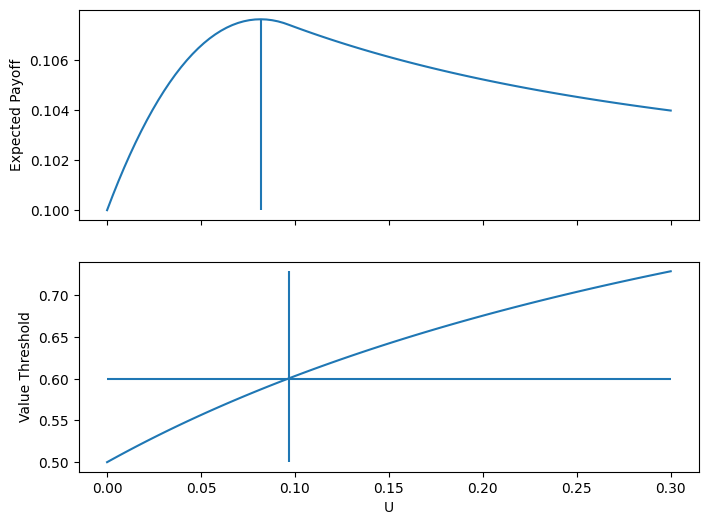

In [42]:
# plot EV(x) for a fixed x as a function of U

Ulims=(0, .3)
x = 0.6
U = np.linspace(Ulims[0], Ulims[1], 100)
payoffs = np.zeros_like(U)
vths = np.zeros_like(U)
for i, u in enumerate(U):
    game_params = {"L": 0, "U": u}
    payoffs[i] = LCP.expected_payoff_x(game_params, x)
    vths[i] = LCP_utils.compute_x5(game_params)

max_i = np.argmax(payoffs)
print(U[max_i])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax1.plot(U, payoffs)
ax1.vlines([U[max_i]], min(payoffs), max(payoffs))
ax1.set_ylabel('Expected Payoff')

ax2.plot(U, vths)
ax2.hlines([x], Ulims[0], Ulims[1])
ax2.vlines([U[np.argmin(np.abs(x-vths))]], min(vths), max(vths))
ax2.set_xlabel('U')
ax2.set_ylabel('Value Threshold')

plt.show()


Rows:   0%|          | 0/1001 [00:00<?, ?it/s]

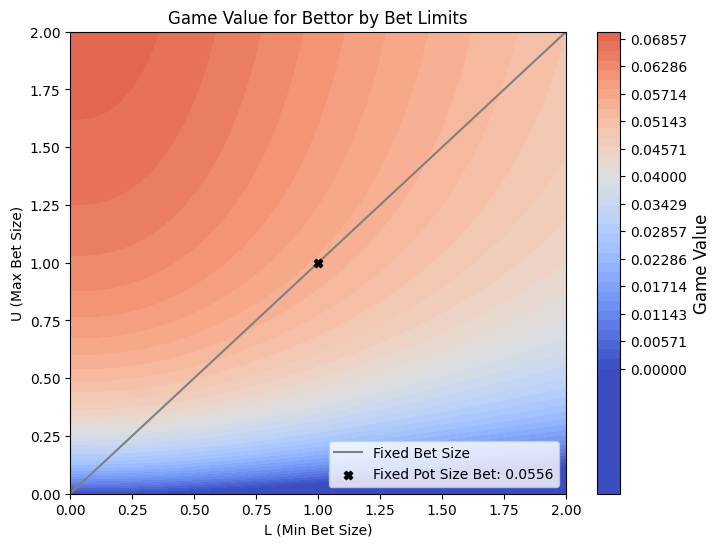

Rows:   0%|          | 0/1001 [00:00<?, ?it/s]

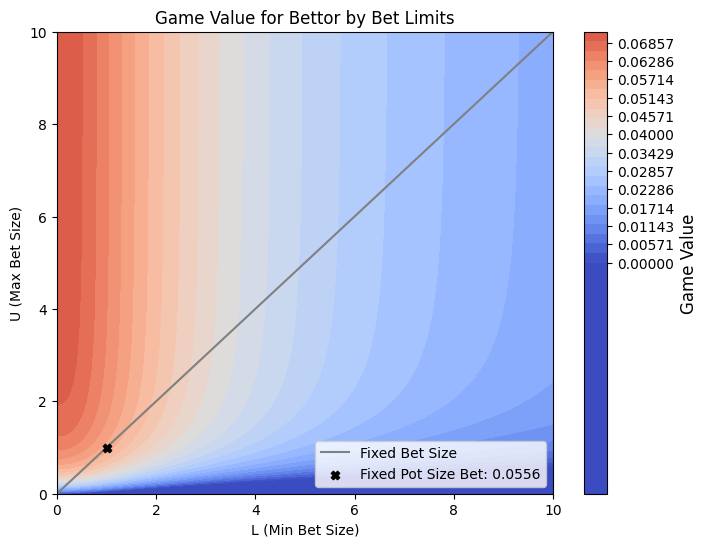

Rows:   0%|          | 0/1001 [00:00<?, ?it/s]

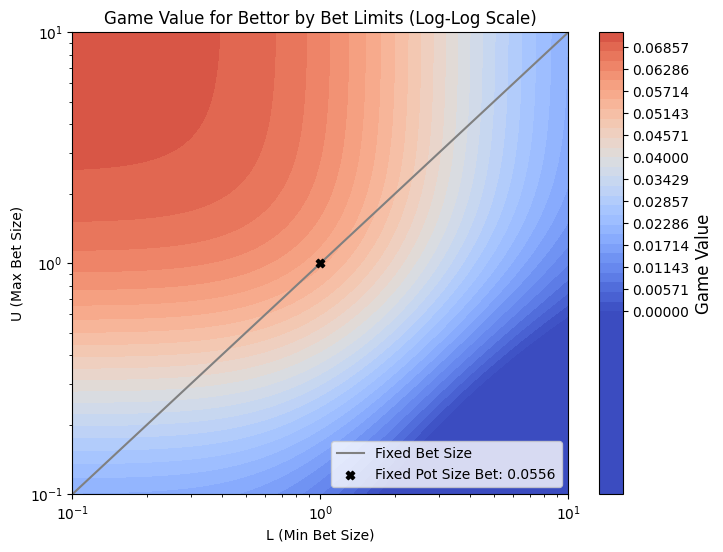

Rows:   0%|          | 0/1001 [00:00<?, ?it/s]

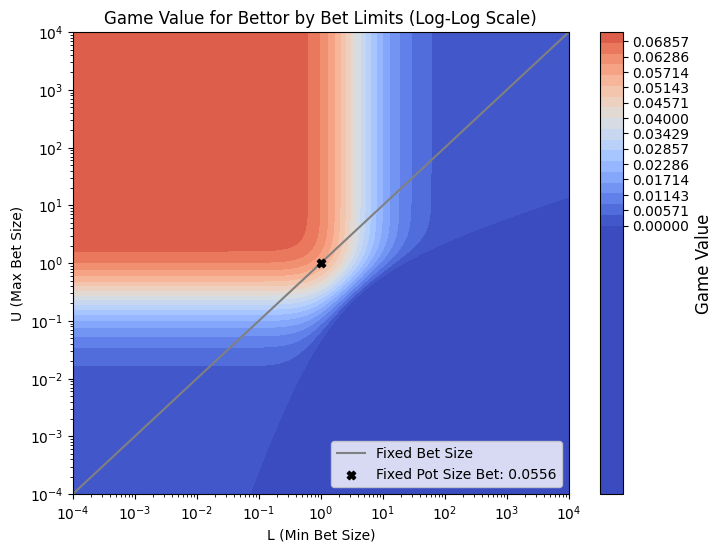

In [13]:
# EXPECTED PAYOFF OVER L, U GRID

def payoffs_over_grid(Ls, Us):
    L_grid, U_grid = np.meshgrid(Ls, Us)

    # Initialize an array to store expected payoffs
    payoff_grid = np.full_like(L_grid, np.nan, dtype=np.float64)

    # Compute expected payoff for each pair (L, U) where L < U
    for i in tqdm(range(L_grid.shape[0]), desc="Rows"):
        for j in range(L_grid.shape[1]):
            L = L_grid[i, j]
            U = U_grid[i, j]
            # if L <= U:
            params = {"L": L, "U": U}
            LCP_utils.clear_cache()
            avg_payoff = LCP.expected_payoff_symbolic(params)
            payoff_grid[i, j] = avg_payoff
    return payoff_grid

def plot_payoff_heatmap(Ls, Us, payoff_grid, cap, log_scale=False, debug=False):

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(Ls, Us, payoff_grid, levels=50, cmap="coolwarm", vmax=0.08, vmin=0)

    # Add a diagonal line from (0, 0) to (cap, cap)
    plt.plot([np.min(Ls), np.max(Ls)], [np.min(Us), np.max(Us)], color="grey", linestyle="-", label="Fixed Bet Size")
    # plt.plot([0, cap], [0, cap], color="grey", linestyle="-", label="Fixed Bet Size")

    # Add a point at (1,1) labeled with the value there, ensuring it is on the line
    value_at_point = payoff_grid[np.argmin(np.abs(Ls - 1)), np.argmin(np.abs(Us - 1))]
    plt.scatter(1, 1, marker="X", color="black", label=f"Fixed Pot Size Bet: {value_at_point:.4f}", zorder=5)
    plt.legend(loc="lower right")  # Move the legend to the bottom right

    # Add a color bar with the same colormap
    cbar = plt.colorbar(contour, ticks=np.linspace(0, 0.08, 15))
    cbar.set_label("Game Value", fontsize=12)

    if debug:
        # pick a random point, call it log(L1), log(U1)
        # find the point reflected across the diagonal: -log(U1), -log(L1)
        # find the payoff at both points and print them
        # also plot both points
        logL1 = np.random.uniform(-np.log10(cap), np.log10(cap))
        logU1 = np.random.uniform(-np.log10(cap), np.log10(cap))
        L1 = 10**logL1
        U1 = 10**logU1
        L2 = 10**(-logU1)
        U2 = 10**(-logL1)
        payoff1 = LCP.expected_payoff_symbolic({"L": L1, "U": U1})
        payoff2 = LCP.expected_payoff_symbolic({"L": L2, "U": U2})
        print(f"Payoff at ({L1:.4f}, {U1:.4f}): {payoff1:.4f}")
        print(f"Payoff at ({L2:.4f}, {U2:.4f}): {payoff2:.4f}")
        plt.scatter(L1, U1, marker="o", color="blue", label=f"Point 1: {payoff1:.4f}", zorder=5)
        plt.scatter(L2, U2, marker="o", color="red", label=f"Point 2: {payoff2:.4f}", zorder=5)

    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim([np.min(Ls), np.max(Ls)])
        plt.ylim([np.min(Us), np.max(Us)])
        plt.title("Game Value for Bettor by Bet Limits (Log-Log Scale)")
    else:
        plt.xlim([0, cap])
        plt.ylim([0, cap])
        plt.title("Game Value for Bettor by Bet Limits")
    plt.xlabel("L (Min Bet Size)")
    plt.ylabel("U (Max Bet Size)")
    plt.show()

grid_size = 1001

cap = 2
Ls = np.linspace(0, cap, grid_size)
Us = np.linspace(0, cap, grid_size)
plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap)

cap = 10
Ls = np.linspace(0, cap, grid_size)
Us = np.linspace(0, cap, grid_size)
plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap)

cap = 10
Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap, log_scale=True)

cap = 10000
Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap, log_scale=True)




Rows:   0%|          | 0/1001 [00:00<?, ?it/s]

Payoff at (0.0060, 0.0047): 0.0012
Payoff at (211.8124, 165.6769): 0.0012


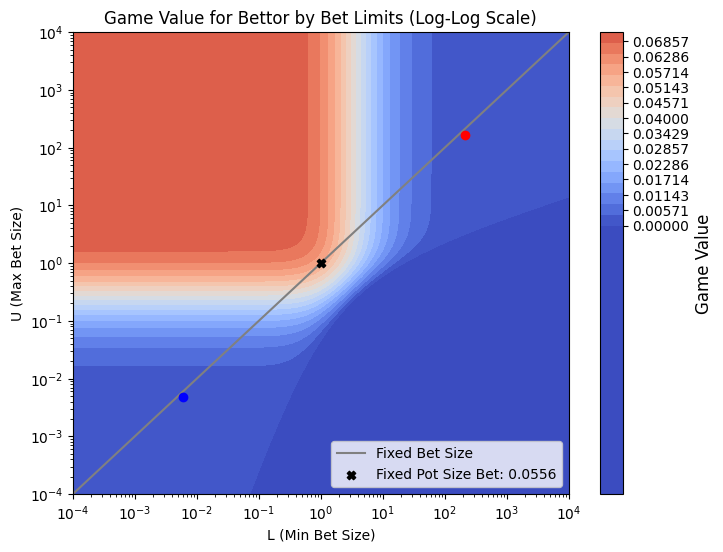

In [ ]:
# why is the log-log image symmetric around y=-x?
cap = 10000
Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap, log_scale=True, debug=True)

In [ ]:
# expected payoff for bettor over x values
